# 实现transformer
本代码自顶向下的实现各个结构，方便留意数据的流向，以及变化
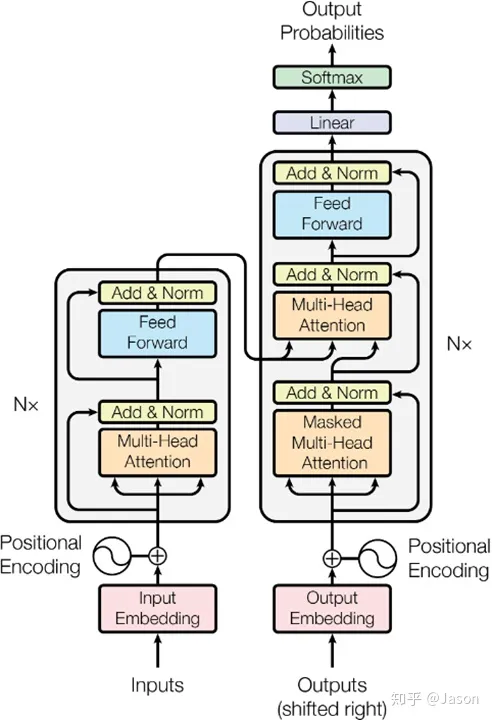

导入库
%matplotlib inline是为了保证代码只能在IPython上运行

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

# Encoder-Decoder
这个结构就是transformer的主体，很容易看懂没什么可以说的\
需要注意的是：Encoder只需输入源序列以及对应的mask\
但是Decoder需要输入Encoder的输出已经对应mask，还要输入正确的输出以及对应mask\
如中译英问题：我倾心于你-I fall in love with you\
'我倾心于你'应输入Encoder\
I fall in love with you 应输入decoder \
具体的mask操作和decoder部分会在后续再次详细说明


In [2]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        #输入的encoder decoder generator必须为实例化的类，其中generator只用于计算模型的参数量，并未参与实际运算
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        #简单封装,参数顺序改变了
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        #对数据进行整理
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        #对数据进行整理
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [3]:
class Generator(nn.Module):
    """
    生成器是一个全连接神经网络和log—softmax组成，作用区间为Encoder-Decoder之后的输出
    全连接的输出维度对应于词表的大小。使输出可以转换回文本形式
    """
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        #log_softmax是为了解决softmax的上溢出和下溢出的问题
        #softmax本质是指数操作，当初始值过大时就会使经过softmax的值超出浮点数能表示的最大范围
        #通过取对数可以有效解决该问题
        return F.log_softmax(self.proj(x), dim=-1)

In [6]:
def clones(module, N):
    """这个函数很有用，因为整个网络结构有多次重复结构，可以用这个函数对实例进行深拷贝，例如可以复制多个Encoder或Linear"""
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

## Encoder
编码器是将源输入提取特征的结构，通过MultiHeadAttention提取包含源序列相关性的特征矩阵
这个结构可以是多层堆叠的，其中N决定了Encoder堆叠了多少次
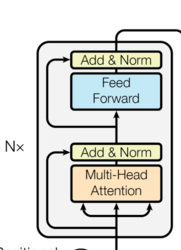

In [5]:
class Encoder(nn.Module):
    "本质就是堆叠了多个EncoderLayer和LayerNorm"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "将数据和mask重复输入每一层"
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

## LayerNorm层归一化
在NLP使用中LayerNorm效果比BatchNorm更好，本质上是将不同词向量的的相同位置进行归一化。\
实际例子：\
\["我爱祖国","吃饭最重要","要是会飞就更好了"\]\
BatchNorm: 将 我 吃 要 三个字的词向量进行归一化\
LayerNorm 我 爱 祖 国 四个词向量做归一化

In [ ]:
class LayerNorm(nn.Module):
    "层归一化"
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        #eps是为了防止分母为0，使得数据爆炸
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

## SublayerConnection
残差和归一化一起实现的单元

In [6]:
class SublayerConnection(nn.Module):
    """
    数据归一化后输入神经网络，dropout后残差链接
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        #sublayer需为实例化的神经网络结构，并且可以保证输入和输出的维度保持一致
        return x + self.dropout(sublayer(self.norm(x)))

## EncoderLayer

In [7]:
class EncoderLayer(nn.Module):
    "输入的必须是实例化的类"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        #两个残差链接，第一个残差链接主体结构为MultiHeadAttention
        #第二个为PositionwiseFeedforward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

## Decoder
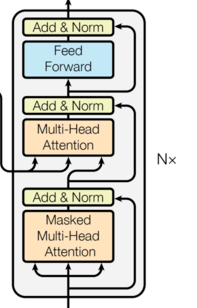
注意Encoder的输入会输入每一层的DecoderLayer


In [8]:
class Decoder(nn.Module):
    "与encoder相似也是N层堆积"
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [9]:
class DecoderLayer(nn.Module):
    "Decoder由两层MultiHeadAttention和一层PositionWiseFeedforward组成"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        #第一层将目标输入的序列mask
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        #第二层将Encoder的输出的序列mask
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

## mask函数
将数据按如下形式进行掩码\
返回黑色的部分为0，黄色的部分为1的矩阵
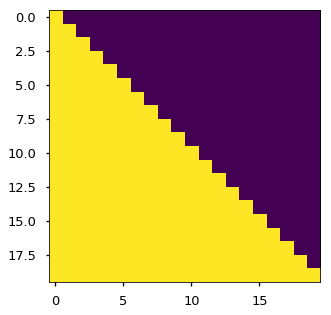

In [10]:
def subsequent_mask(size):
    "掩码操作"
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

## SelfAttention
Attention 并不会改变数据的形状\
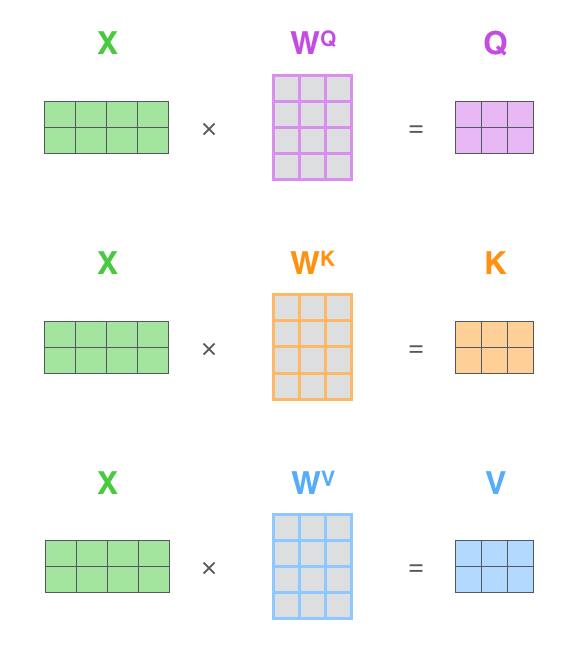
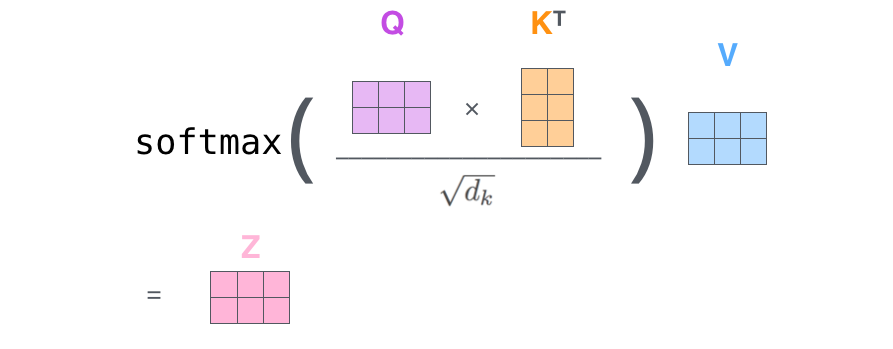

In [11]:
def attention(query, key, value, mask=None, dropout=None):
    "普通的点积型注意力"
    #输入的QKV的维度为(batch,head,quelen,d_k)d_k为分头后的数据
    d_k = query.size(-1)
    #只对后两维进行矩阵乘法，保证多头注意力，各个头的数据隔离
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        #如果有掩码，则将数据替换为-1e9(接近无穷小)
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

## MultiHeadAttention
多头注意力机制  将(batch,seqlen,d_model)的数据变形为(batch,seqlen,head,d_model/head)并且head输入对应的头里，每个头都是一个注意力机制
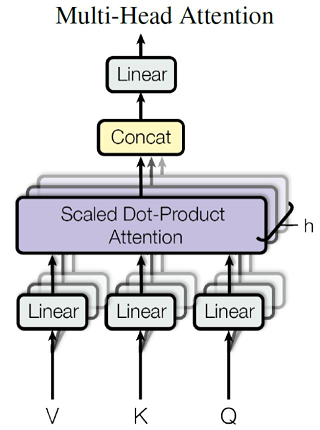

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "需要输入head数以及d_model,head需要可以整除d_model"
        "多头的目的是让不同的头提取的特征不同，以丰富模型的特征提取"
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # 算出分多头后的维度 如512维 八头维度变为(8,64)
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        #如果有mask操作在第一个维度后加入维度
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 先分别将QKV分别输入线性回归中，然后将得到的QKV分别将维度划分多头
        #shape=(batch,seqlen,d_model)->Linear(维度不变)->(batch,head,seqlen,d_k)
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 将分好头的数据输入Attention，并得出结果
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) 将数据还原为原来的样子 shape=(batch,seqlen,d_model)
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

## Position-wise FNN
一层FNN->Relu->dropout->FNN

In [ ]:
class PositionwiseFeedForward(nn.Module):
    "没啥可说的就是简单的FNN"
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## Embedding
这里使用了nn.Embedding
这是一个可以学习的词嵌入模型,会在训练过程中学习更好的将词转为向量化，但是该函数的输入需要为一个longtensor，即输入的是一个词（中文为字）的id，对于文本词量大的情况可以使用transformers.BertTokenizer对文本进行id话，如果文本词数较少，可以自己制作一个词id映射字典，例如将“我爱你中国”映射为1,2,3,4,5 这就是id映射，没有什么复杂的内容

In [3]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        #这里将数据乘以根号d_model
        return self.lut(x) * math.sqrt(self.d_model)

## Positional Encoding
位置编码，在原始论文中，分别对奇偶位置的编码分别采用sin和cos编码，使用线性函数的原因，是因为要保证每次输入时相同位置数据的编码信息一致。并且编码信息是直接与原始数据相加的，所以线性的函数可以更方便的使神经网络学习，达到减少工作量的目的\
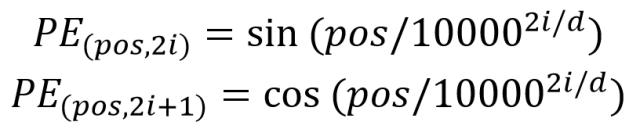

In [ ]:
class PositionalEncoding(nn.Module):
    "PositionalEncoding位置编码"
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        #生成一个拥有很多位的位置编码的矩阵
        #1.创建一个空矩阵维度如下
        #shape=(seqmaxlen,d_model)  seqmaxlen为一句话中最多可有多少个词
        pe = torch.zeros(max_len, d_model)
        #生成一个数组并且给它扩充维度
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        #从第0个词开始步长为2，取单数词，用sin
        pe[:, 0::2] = torch.sin(position * div_term)
        #从第1个词开始步长为2，取单数词，用cos
        pe[:, 1::2] = torch.cos(position * div_term)
        #为位置编码增加对应于batch维度，方便后续操作
        pe = pe.unsqueeze(0)
        #将pe注册为类型中的变量，但是并不参与训练
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

In [ ]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "构建整个模型，并返回一个实例化的的EncoderDecoder对象"
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        #这个生成器并没有实际使用，只能用于计算模型的参数量
        Generator(d_model, tgt_vocab))
    
    # 这步很重要，因为我们创建模型时大量使用了深拷贝，所以当创建好模型后，
    #模型中的参数实际上是一样的，需要使用正则初始化将所有的参数重新初始化
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

## Batch 数据封装类
因为是NLP任务，所以数据有源输入、目标输入、源掩码、目标掩码的数据，所以用一个类封装起来更方便使用,应将训练数据和测试数据封装进该函数

这里的数据已经是id化的数据了并且已经添加了起止符和padding
如\
我倾心于你->\[1,5,4,7,8,22,2,0,0,0\]  其中1为起始符的id 2为结束符的id 0为pad的id

In [4]:
class Batch:
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        """
        因为transformer模型的输入是一次输入所有的信息，所以为了保证矩阵维度一致会
        加入[pad]符号填充没有字的地方，那么当pad！=0时可以用此方法将没有数据的
        部分变成0
        """
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            #目标是输入src trg[:-1]预测trg[1:]
            #输入decoder的数据 去除截止符
            self.trg = trg[:, :-1]
            #应输出decoder的数据，去除了起始符
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            #这句话中实际有多少个词  包括截止符
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "将自动填充的pad遮蔽加速运算，并且对trg数据进行遮蔽"
        #首先生成与词长度一样的矩阵，pad位置的数据为0，包含词的位置为1
        #再在最后一个维度前添加一个新维度
        #shape=(batch,seqlen)->(batch,1,seqlen)
        tgt_mask = (tgt != pad).unsqueeze(-2)
        #通过正常的掩码函数生成一个掩码举证，两个矩阵取于操作
        #等价于将斜对角线以上的数据以及pad的数据一同遮蔽
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

## 优化函数
优化函数用的是Adam,学习率是会自动变化的，这个自定义的优化函数会在训练时自动调节训练速度并且有了热身过程，热身次数前学习速率递增，热身次数后学习速率下降

In [5]:
class NoamOpt:
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "通过梯度优化模型"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "重新计算学习率"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

## 标签平滑
将标签的0变成比0稍大的数，将1缩小。目的是让模型不要太傲慢，自然界中的事务不应该被100%判断，而softmax函数会非常乐意促进这一现象，即让正确的位置的预测值接近无穷大，让其他位置接近于0.这非常利于训练，但是对真实的使用会有影响，反而会让模型傲的慢做出更加极端的判断。即完全确信这个字应该是某个字。

In [ ]:
class LabelSmoothing(nn.Module):
    "实现了标签平滑"
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))